### Evaluate mooring:
There is 5 year of observations from a mooring in front of Pine Island Glacier. 
We will check how these observations align with the model output

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cf_xarray
import cartopy.crs as ccrs
import cmocean as cm
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
from dask.distributed import Client
import matplotlib.path as mpath
import scipy as sp
import scipy.interpolate
import scipy.ndimage
import scipy.io
import scipy.stats
import pandas as pd
from pandas import DataFrame
import cartopy.feature as cft
from metpy.interpolate import cross_section
from pathlib import Path
import xgcm
from pyproj import Proj, transform
import datetime
import gsw

In [2]:
client = Client(n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/32963/status,
Dashboard: /proxy/32963/status,Workers: 8
Total threads: 8,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38037,Workers: 8
Dashboard: /proxy/32963/status,Total threads: 8
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:44175,Total threads: 1
Dashboard: /proxy/43031/status,Memory: 15.65 GiB
Nanny: tcp://127.0.0.1:33125,


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [4]:
# This one is probably the most important function. Could check if it can be simplified and / or if there is a function available in a module that does the same. 

def lagcorr(x,y,lag=None,verbose=True):
    '''Compute lead-lag correlations between 2 time series.

    <x>,<y>: 1-D time series.
    <lag>: lag option, could take different forms of <lag>:
          if 0 or None, compute ordinary correlation and p-value;
          if positive integer, compute lagged correlation with lag
          upto <lag>;
          if negative integer, compute lead correlation with lead
          upto <-lag>;
          if pass in an list or tuple or array of integers, compute 
          lead/lag correlations at different leads/lags.

    Note: when talking about lead/lag, uses <y> as a reference.
    Therefore positive lag means <x> lags <y> by <lag>, computation is
    done by shifting <x> to the left hand side by <lag> with respect to
    <y>.
    Similarly negative lag means <x> leads <y> by <lag>, computation is
    done by shifting <x> to the right hand side by <lag> with respect to
    <y>.

    Return <result>: a (n*2) array, with 1st column the correlation 
    coefficients, 2nd column correpsonding p values.

    Currently only works for 1-D arrays.
    '''

    import numpy
    from scipy.stats import pearsonr

    if len(x)!=len(y):
        raise('Input variables of different lengths.')

    #--------Unify types of <lag>-------------
    if numpy.isscalar(lag):
        if abs(lag)>=len(x):
            raise('Maximum lag equal or larger than array.')
        if lag<0:
            lag=-numpy.arange(abs(lag)+1)
        elif lag==0:
            lag=[0,]
        else:
            lag=numpy.arange(lag+1)    
    elif lag is None:
        lag=[0,]
    else:
        lag=numpy.asarray(lag)

    #-------Loop over lags---------------------
    result=[]
    if verbose:
        print('\n#<lagcorr>: Computing lagged-correlations at lags:',lag)

    for ii in lag:
        if ii<0:
            result.append(pearsonr(x[:ii],y[-ii:]))
        elif ii==0:
            result.append(pearsonr(x,y))
        elif ii>0:
            result.append(pearsonr(x[ii:],y[:-ii]))

    result=numpy.asarray(result)

    return result

In [5]:
def make_movie(instr, outstr):
    import glob 
    import cv2

    img_array = []
    for filename in glob.glob(instr):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)

    out = cv2.VideoWriter(outstr,cv2.VideoWriter_fourcc(*'DIVX'), 2, size)
 
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

In [6]:
geolon_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_t
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

In [7]:
def make_boundary_path(longitudes, latitudes):
    """
    Return a path around boundary to create a sector map, then cut it out given
    longitudes and latitudes.
    """
    boundary_path = np.array([longitudes[-1, :], latitudes[-1, :]])
    boundary_path = np.append(boundary_path, np.array([longitudes[::-1, -1], latitudes[::-1, -1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([longitudes[1, ::-1],  latitudes[1, ::-1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([longitudes[:, 1],     latitudes[:, 1]]), axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

In [8]:
# Define sector maps 
# West Antarctica:
midlon = -100
maxlon = -40
minlon = -160
minlat = -80
maxlat = -60
midlat = (minlat + maxlat)/2
lons = geolon_t.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = geolat_t.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
boundary_path_wa = make_boundary_path(lons, lats)
extent_wa = [minlon,maxlon,minlat,maxlat]
projection_wa=ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

# Amundsen Sea
midlon = -105
maxlon = -85
minlon = -125
minlat = -78
maxlat = -68
midlat = (minlat + maxlat)/2
lons = geolon_t.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = geolat_t.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
boundary_path_am = make_boundary_path(lons, lats)
extent_am = [minlon,maxlon,minlat,maxlat]
projection_am = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

# Amundsen Sea large
midlon = -105
maxlon = -75
minlon = -135
minlat = -78
maxlat = -65
midlat = (minlat + maxlat)/2
lons = geolon_t.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = geolat_t.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
boundary_path_aml = make_boundary_path(lons, lats)
extent_aml = [minlon,maxlon,minlat,maxlat]
projection_aml = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

# Amundsen Sea coastal
midlon = -105
maxlon = -75
minlon = -135
minlat = -77
maxlat = -70
midlat = (minlat + maxlat)/2
lons = geolon_t.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = geolat_t.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
boundary_path_amc = make_boundary_path(lons, lats)
extent_amc = [minlon,maxlon,minlat,maxlat]
projection_amc = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

# Pine Island Bay
midlon = -105
maxlon = -98
minlon = -115
minlat = -76
maxlat = -71.7
midlat = (minlat + maxlat)/2
lons = geolon_t.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = geolat_t.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
boundary_path_pib = make_boundary_path(lons, lats)
extent_pib = [minlon,maxlon,minlat,maxlat]
projection_pib = ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

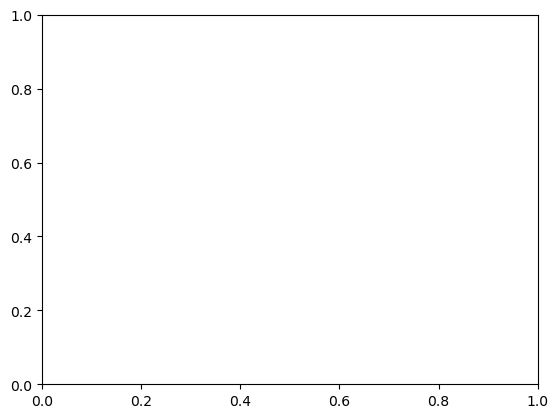

In [9]:
def spatial_plot(pattern, levels = None, cell='u', ax=plt.gca(), sect = 'am', cmap = cm.cm.balance, extend='both'):
    if sect == 'am':
        extent = extent_am
        boundary_path = boundary_path_am
    elif sect == 'wa':
        extent = extent_wa
        boundary_path = boundary_path_wa
    elif sect == 'aml':
        extent = extent_aml
        boundary_path = boundary_path_aml
    elif sect == 'amc':
        extent = extent_amc
        boundary_path = boundary_path_amc
    elif sect == 'pib':
        extent = extent_pib
        boundary_path = boundary_path_pib
    if levels == 'None':
        levels = np.linspace(-np.nanmax(abs(pattern)), 1.1*np.nanmax(abs(pattern)),21)
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
    ax.coastlines(resolution='50m')
    ax.gridlines()
    ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
    if cell == 'u':
        p1 = pattern.plot.contourf(ax=ax,
                    x='xu_ocean', y='yu_ocean', levels = levels, add_colorbar = False, cmap=cmap, extend=extend,
                    transform=ccrs.PlateCarree())
    elif cell == 't':
        p1 = pattern.plot.contourf(ax=ax,
                    x='xt_ocean', y='yt_ocean', levels = levels, add_colorbar = False, cmap=cmap, extend=extend,
                    transform=ccrs.PlateCarree())
    p2 = ht.plot.contour(ax=ax,
                   x='xt_ocean', y='yt_ocean', levels=[1000], colors='k',linewidth=1,
                   transform=ccrs.PlateCarree())
    return p1, p2

In [10]:
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='gray', linewidth=0.5)
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [11]:
# Load mooring data. Position roughly: 102W,75.05S
mo_data = scipy.io.loadmat('/g/data/jk72/or6852/BSR5.mat')
mo_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Mon Feb 17 19:42:52 2014',
 '__version__': '1.0',
 '__globals__': [],
 'bsr5': array([[(array([[-101.05593333]]), array([[-75.05593333]]), array([[47.74214938]]), array([[(array([[733795.39585022],
                        [733795.4062669 ],
                        [733795.41668357],
                        ...,
                        [735645.69898033],
                        [735645.709397  ],
                        [735645.71981368]]), array([[1.2093],
                        [1.2095],
                        [1.2095],
                        ...,
                        [1.0874],
                        [1.0946],
                        [1.0963]]), array([[30.197949],
                        [30.200251],
                        [30.200487],
                        ...,
                        [29.928134],
                        [29.931016],
                        [29.934015]]), array([[792.764],
                 

In [25]:
data = mo_data['bsr5'] # Has data for several instruments (different depths) over 5 years 
time1 = pd.to_datetime(data[0][0][3][0][0][0][:,0]-719529, unit='D')
temp1 = data[0][0][3][0][0][1][:,0]
cond1 = data[0][0][3][0][0][2][:,0]
pres1 = data[0][0][3][0][0][3][:,0]
dept1 = data[0][0][3][0][0][4][:,0]
#mo1 = np.concatenate((time1,temp1,dept1),axis=1)
# The gsw module has several functions for converting different units. We will use it to convert from in-situ temperature (moorings) to conservative temperature (model).
# Needs absolute salinity as input. We could calculate that from conductivity for some moorings but it does not matter much so we just use 35 for now. 
ct1 = gsw.conversions.CT_from_t(35,temp1,pres1) 
sp1 = gsw.conversions.SP_from_C(cond1,temp1,pres1)
sa1 = gsw.conversions.SA_from_SP(sp1,pres1,-102,-75)

In [26]:
time2 = pd.to_datetime(data[0][0][4][0][0][0][:,0]-719529, unit='D')
temp2 = data[0][0][4][0][0][1][:,0]
cond2 = data[0][0][4][0][0][2][:,0]
pres2 = data[0][0][4][0][0][3][:,0]
dept2 = data[0][0][4][0][0][4][:,0]
ct2 = gsw.conversions.CT_from_t(35,temp2,pres2)
sp2 = gsw.conversions.SP_from_C(cond2,temp2,pres2)
sa2 = gsw.conversions.SA_from_SP(sp2,pres2,-102,-75)
time3 = pd.to_datetime(data[0][0][5][0][0][0][:,0]-719529, unit='D')
temp3 = data[0][0][5][0][0][1][:,0]
pres3 = data[0][0][5][0][0][2][:,0]
dept3 = data[0][0][5][0][0][3][:,0] # here index 3 is depth
ct3 = gsw.conversions.CT_from_t(35,temp3,pres3)
time4 = pd.to_datetime(data[0][0][6][0][0][0][:,0]-719529, unit='D')
temp4 = data[0][0][6][0][0][1][:,0]
pres4 = data[0][0][6][0][0][2][:,0]
dept4 = data[0][0][6][0][0][3][:,0]
ct4 = gsw.conversions.CT_from_t(35,temp4,pres4)
time5 = pd.to_datetime(data[0][0][7][0][0][0][:,0]-719529, unit='D')
temp5 = data[0][0][7][0][0][1][:,0]
pres5 = data[0][0][7][0][0][2][:,0]
dept5 = data[0][0][7][0][0][3][:,0]
ct5 = gsw.conversions.CT_from_t(35,temp5,pres5)

In [27]:
# create xr datasets for monthly means
mo_xr_1 = xr.Dataset({'T':("time",temp1),'CT':("time",ct1),'SA':("time",sa1),'d':("time",dept1),"time":time1})
mo_xr_mon_1 = mo_xr_1.resample({'time':'M'}).mean('time')

mo_xr_2 = xr.Dataset({'T':("time",temp2),'CT':("time",ct2),'SA':("time",sa2),'d':("time",dept2),"time":time2})
mo_xr_mon_2 = mo_xr_2.resample({'time':'M'}).mean('time')

mo_xr_3 = xr.Dataset({'T':("time",temp3),'CT':("time",ct3),'d':("time",dept3),"time":time3})
mo_xr_mon_3 = mo_xr_3.resample({'time':'M'}).mean('time')

mo_xr_4 = xr.Dataset({'T':("time",temp4),'CT':("time",ct4),'d':("time",dept4),"time":time4})
mo_xr_mon_4 = mo_xr_4.resample({'time':'M'}).mean('time')

mo_xr_5 = xr.Dataset({'T':("time",temp5),'CT':("time",ct5),'d':("time",dept5),"time":time5})
mo_xr_mon_5 = mo_xr_5.resample({'time':'M'}).mean('time')

Text(0, 0.5, 'Salinity')

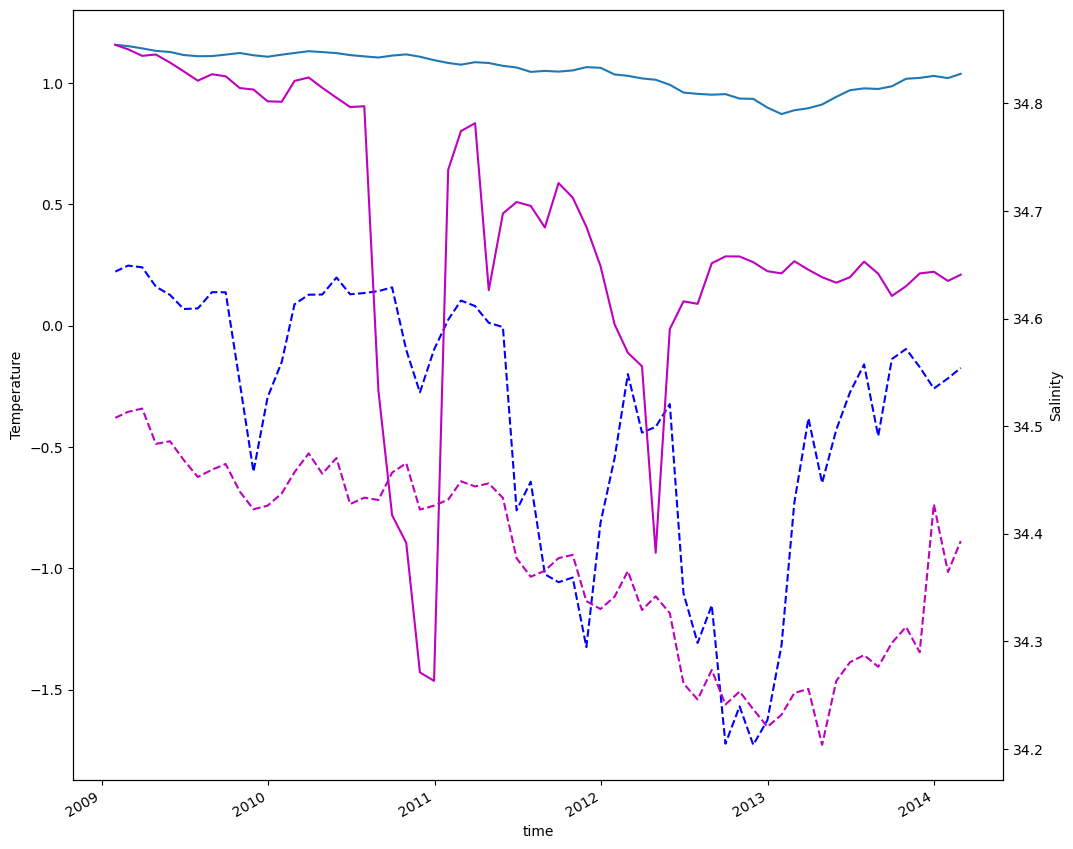

In [34]:
fig, ax =plt.subplots(1,1,figsize=(12,10))
mo_xr_mon_1.CT.plot(ax = ax)
axb= ax.twinx()
mo_xr_mon_1.SA.plot(ax=axb, color='m')
mo_xr_mon_2.CT.plot(ax=ax,color='b',ls='--')
mo_xr_mon_2.SA.plot(ax=axb,color='m',ls='--')
ax.set_ylabel('Temperature')
axb.set_ylabel('Salinity')

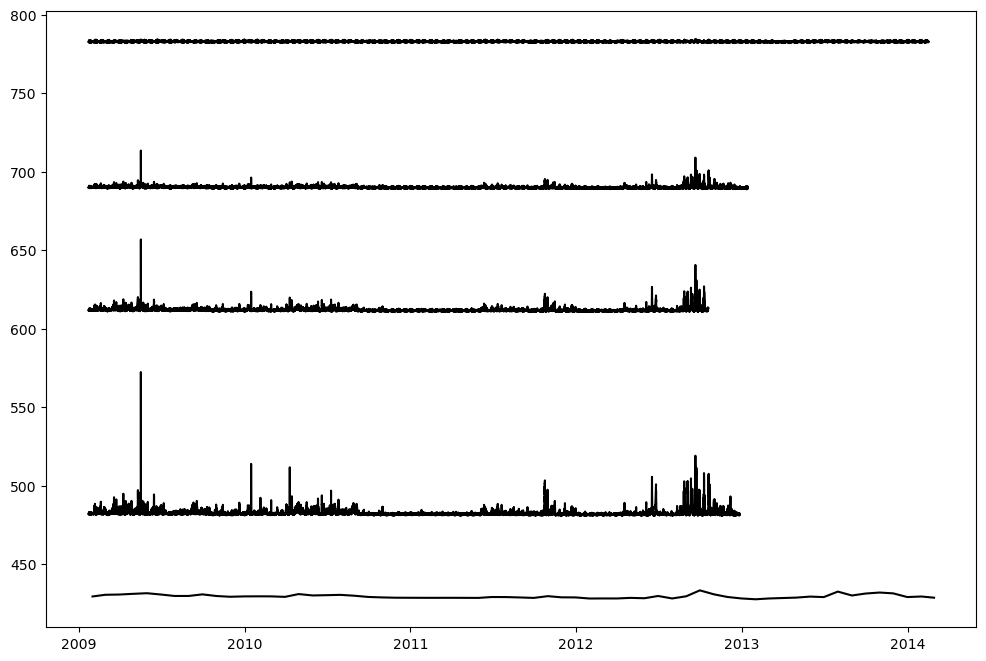

In [15]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(time1,dept1,'k')
ax.plot(mo_xr_mon_2.time,mo_xr_mon_2.d,'k')
ax.plot(time3,dept3,'k')
ax.plot(time4,dept4,'k')
ax.plot(time5,dept5,'k')


In [16]:
# load ocean temperature from model 
experiment = '01deg_jra55v140_iaf_cycle2'
start = '2009-01-01 00:00:00' # start date, from 2009
end = '2019-01-01 00:00:00' # end date


t = cc.querying.getvar(experiment, 'temp', session,
                       start_time=start, end_time=end).sel(yt_ocean=slice(-77,-72)).sel(xt_ocean=slice(-115,-95)).sel(st_ocean=slice(0,1000))
area_t = cc.querying.getvar(experiment,'area_t',session, n=-1).sel(yt_ocean=slice(-77,-72)).sel(xt_ocean=slice(-115,-95)).fillna(1.0).astype(int) - 1
area_t.load()
ht = cc.querying.getvar(experiment, 'ht', session, n=1).sel(yt_ocean=slice(-77,-72)).sel(xt_ocean=slice(-115,-95)).load()

t

<xarray.DataArray 'temp' (time: 123, st_ocean: 46, yt_ocean: 118, xt_ocean: 200)>
dask.array<getitem, shape=(123, 46, 118, 200), dtype=float32, chunksize=(1, 19, 81, 150), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -115.0 -114.9 -114.8 ... -95.25 -95.15 -95.05
  * yt_ocean  (yt_ocean) float64 -76.97 -76.93 -76.88 ... -72.11 -72.07 -72.03
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 4.332 ... 766.1 843.0 926.6
  * time      (time) datetime64[ns] 2008-10-16T12:00:00 ... 2018-12-16T12:00:00
Attributes: (12/13)
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    ...             ...
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2020-08-20
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

In [17]:
t_model = t.load()-273.15

In [18]:
latoff = .1
lonoff = .2

lonw = -102.05 - lonoff
lone = -101.95 + lonoff
lats = -75.04 - latoff
latn = -74.99 + latoff
print(t_model.sel(yt_ocean = slice(lats,latn)).sel(xt_ocean = slice(lonw,lone)).shape[-2:])
t_model_mooring = t_model.sel(yt_ocean = slice(lats,latn)).sel(xt_ocean = slice(lonw,lone)).weighted(area_t).mean(dim=('xt_ocean','yt_ocean')).resample({'time':'M'}).mean('time')
t_model_mooring

(6, 5)


<xarray.DataArray 'temp' (time: 123, st_ocean: 46)>
array([[-1.75034018, -1.74501688, -1.73483272, ...,  0.66526698,
         0.65468561,  0.64454283],
       [-1.57857515, -1.56108717, -1.54258813, ...,  0.68174199,
         0.66702668,  0.65419541],
       [-0.56118568, -0.58324781, -0.60415591, ...,  0.70819954,
         0.68804279,  0.66985381],
       ...,
       [-1.70872306, -1.70590366, -1.70065642, ...,  0.57506228,
         0.58034149,  0.58079211],
       [-1.60908046, -1.59887433, -1.58640466, ...,  0.59579179,
         0.60251803,  0.60215822],
       [-0.33962962, -0.34988273, -0.36738179, ...,  0.6060663 ,
         0.61366642,  0.61463089]])
Coordinates:
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 4.332 ... 766.1 843.0 926.6
  * time      (time) datetime64[ns] 2008-10-31 2008-11-30 ... 2018-12-31

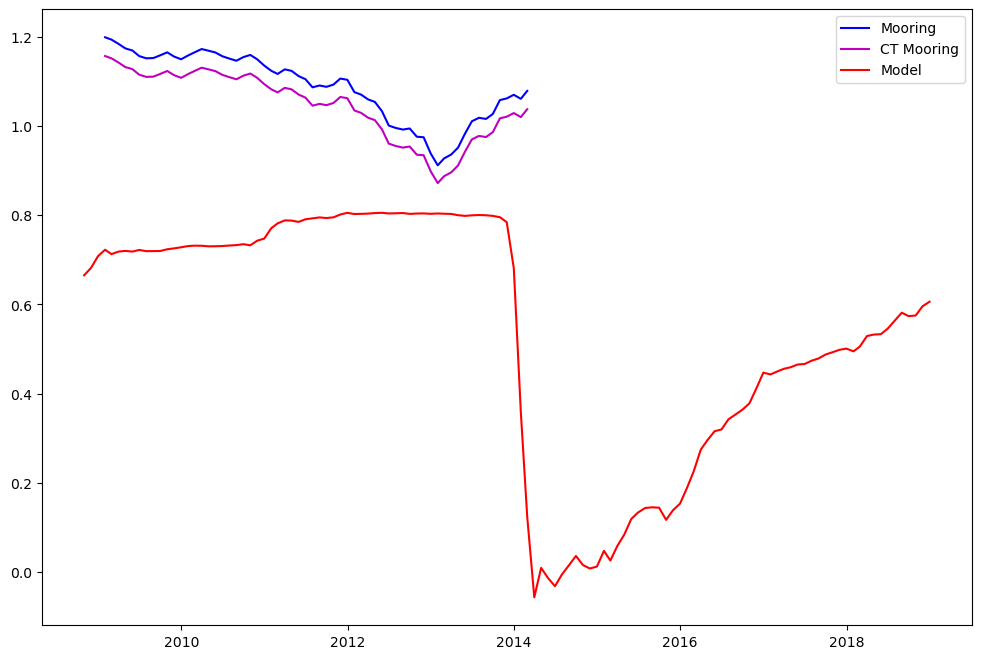

In [19]:
# Make simple comparison plots for each instrument
depth = [429,482,612,690,782]
instr = [2,5,4,3,1] # instruments ordered from top to bottom
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(mo_xr_mon_1.time,mo_xr_mon_1.T,'b',label='Mooring')
ax.plot(mo_xr_mon_1.time,mo_xr_mon_1.CT,'m',label='CT Mooring')
ax.plot(t_model_mooring.time,t_model_mooring.sel(st_ocean=depth[4],method='nearest'),'r',label='Model')
ax.legend()

In [20]:
ts = '2009-01-15'
te = '2013-01-31'
r = 3
c = 1
l = lagcorr(mo_xr_mon_2.T.sel(time=slice(ts,te)).rolling(time=r, center=True).mean()[c:-c], t_model_mooring.sel(st_ocean=429,method='nearest').sel(time=slice(ts,te)).rolling(time=r, center=True).mean()[c:-c] , lag=12) # correlation to basal melting PIB
l


#<lagcorr>: Computing lagged-correlations at lags: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


array([[0.21276174, 0.15104715],
       [0.13284578, 0.37879554],
       [0.06961394, 0.64954421],
       [0.04325368, 0.78041122],
       [0.08305677, 0.59645372],
       [0.19358661, 0.21930313],
       [0.35214439, 0.02394803],
       [0.46318279, 0.00261424],
       [0.49464073, 0.00136972],
       [0.46477139, 0.00328379],
       [0.40347744, 0.01327494],
       [0.32215439, 0.05534666],
       [0.15720891, 0.36710502]])


#<lagcorr>: Computing lagged-correlations at lags: [0]

#<lagcorr>: Computing lagged-correlations at lags: [0]

#<lagcorr>: Computing lagged-correlations at lags: [0]

#<lagcorr>: Computing lagged-correlations at lags: [0]

#<lagcorr>: Computing lagged-correlations at lags: [0]


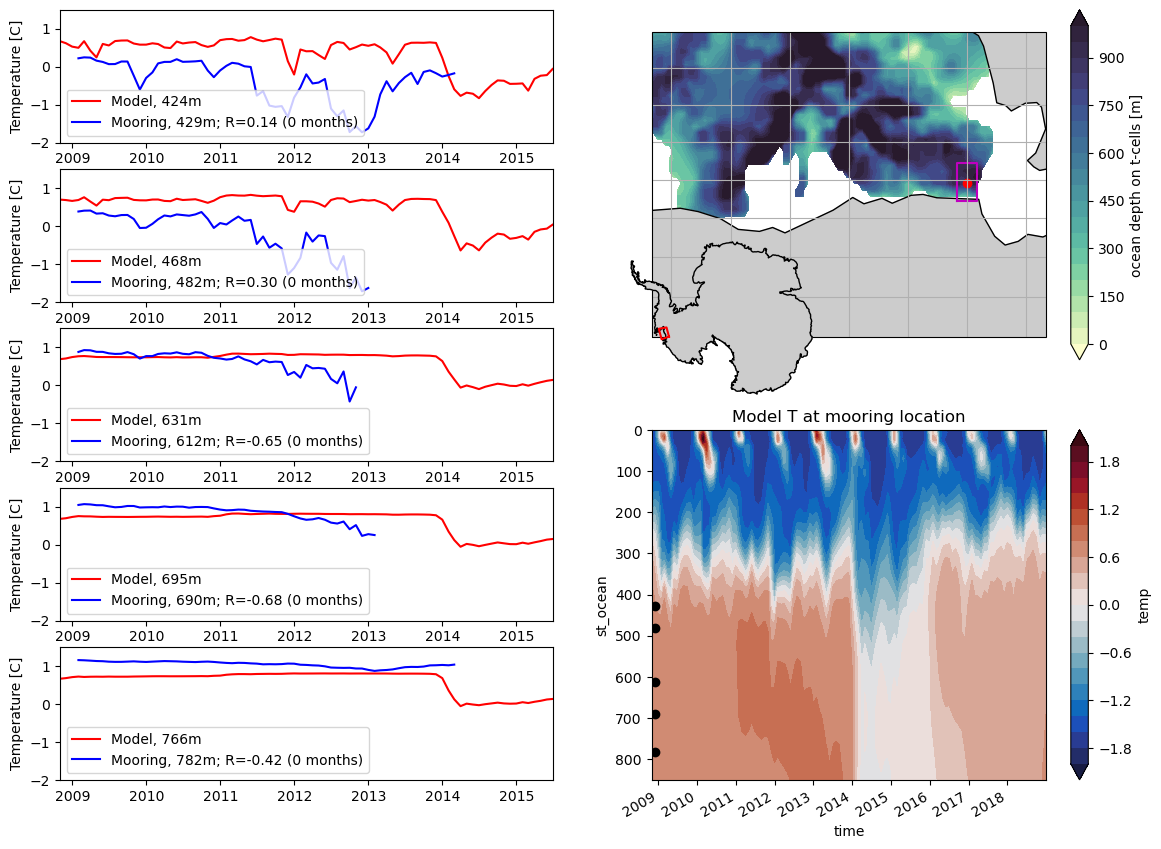

In [21]:
# Make a good plot: small map indicating the location, timeseries of the 5 instruments + model comparison and maybe a Hovmoller (?)
r = 3
c = 1
fig = plt.figure(figsize=(14,10))
for i in range(5):
    ax = plt.subplot(5,2,2*i+1)
    d_mod = t.st_ocean.sel(st_ocean=depth[i],method='nearest').values
    mod_pl = t_model_mooring.sel(st_ocean=depth[i],method='nearest')
    ax.plot(t_model_mooring.time,mod_pl,'r',label='Model, %.0fm' %(d_mod))
    if i==0:
        ds = mo_xr_mon_2
    elif i==1:
        ds = mo_xr_mon_5
    elif i==2:
        ds = mo_xr_mon_4
    elif i==3:
        ds = mo_xr_mon_3
    elif i==4:
        ds = mo_xr_mon_1
    l = lagcorr( mod_pl.sel(time = slice(ds.time[0],ds.time[-1])).rolling(time=r,center=True).mean()[c:-c], ds.CT.sel(time = slice(ds.time[0],ds.time[-1])).rolling(time=r,center=True).mean()[c:-c],lag = 0)
    lmax = np.where(l[:,0] == np.amax(l[:,0]))[0] # find year of max correlation
    ax.plot(ds.time,ds.CT,'b',label='Mooring, %dm; R=%.2f (%d months)' %(depth[i], l[lmax[0],0], lmax[0]))

    ax.set_ylabel('Temperature [C]')
    ax.legend()
    ax.set_xlim([t_model_mooring.time.values[0],t_model_mooring.sel(time='2015-07-01 00:00:00', method='nearest').time.values])
    ax.set_ylim([-2,1.5])

ax2 = plt.subplot(2,2,2,projection = ccrs.Mercator(central_longitude=-105, min_latitude=-76, max_latitude=-74))
ax2.set_extent([-110, -100, -76, -74], crs=ccrs.PlateCarree())
ax2.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax2.coastlines(resolution='50m')
ax2.gridlines()
ht.plot.contourf(ax=ax2,
                     x='xt_ocean',y='yt_ocean',levels = np.linspace(0,1000,21), cmap=cm.cm.deep, extend='both',
                       transform=ccrs.PlateCarree())
ax2.plot([lonw,lone,lone,lonw,lonw],[lats,lats,latn,latn,lats], 'm', transform = ccrs.PlateCarree())
ax2.plot([-102],[-75.02],'r', marker='o', transform = ccrs.PlateCarree())
    
ax4 = plt.subplot(2,2,4)
t_model_mooring.plot.contourf(ax=ax4,x='time',y='st_ocean', levels = np.linspace(-2,2,21),extend='both',cmap = cm.cm.balance)
ax4.scatter([t_model_mooring.time.values[1],t_model_mooring.time.values[1],t_model_mooring.time.values[1],t_model_mooring.time.values[1],t_model_mooring.time.values[1]],[depth],color='k', marker='o')
ax4.set_ylim([850,0])
ax4.set_title('Model T at mooring location')

ax3 = fig.add_axes((0.55,0.55,0.013,0.013),projection = ccrs.SouthPolarStereo())
#ax3.set_extent([-280, -80, -80, -68], crs=ccrs.PlateCarree())
ax3.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax3.coastlines(resolution='50m')
ax3.set_boundary(circle, transform=ax.transAxes)
ax3.plot([-110,-100,-100,-110,-110],[-76,-76,-74,-74,-76],'r',transform = ccrs.PlateCarree())

#plt.savefig('/home/581/or6852/plots/mooring_comparison_6x6_avg.png')

First plots indicate that:
- There is little to no variability in the ocean model below 600m 
- Above 500 m model is able to capture some details of the mooring record
- Weird temperature drop in the model at all depth in 2014
- Correlation of higher depth (shallower than 500m ) seems decent but there is so little variability that this does not mean anything
- Note that the time period is colder than usual in the model! (But apparently not cold enough)

In [22]:
np.expand_dims(temp2,1).shape

(177632, 1)

(750.0, 400.0)

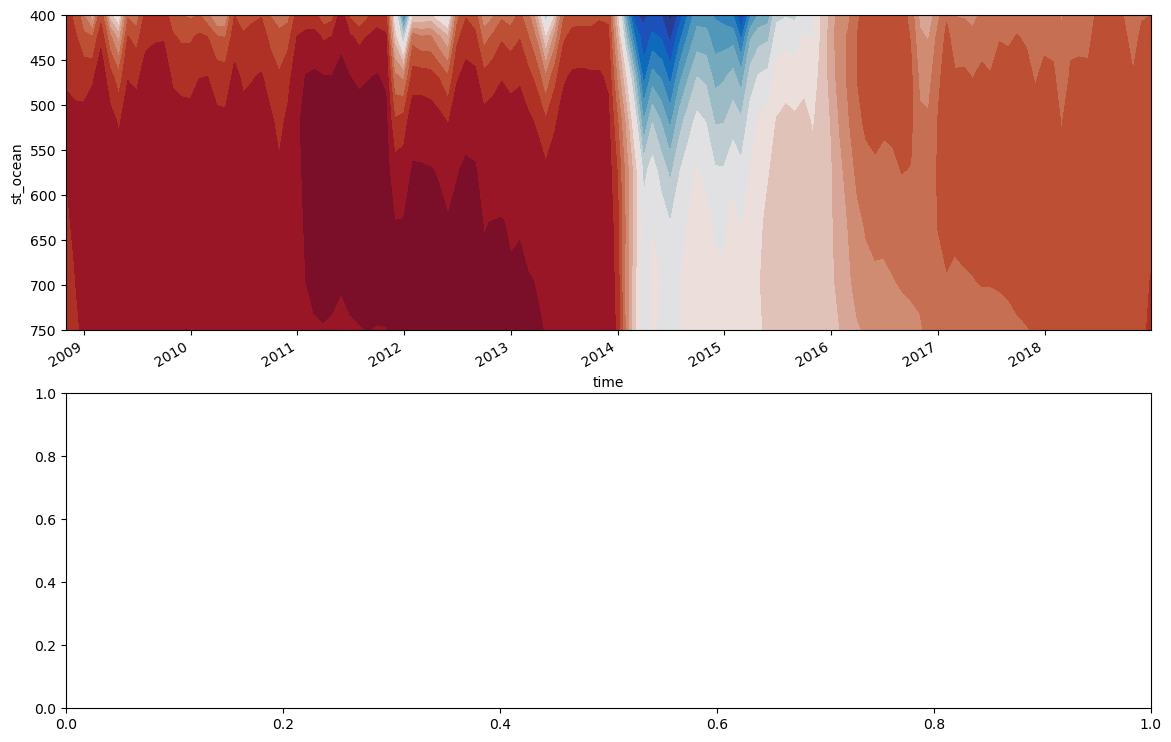

In [23]:
fig, ax = plt.subplots(2,1,figsize=(14,9))
t_model_mooring.plot.contourf(ax=ax[0],x='time',y='st_ocean',add_colorbar = False, levels = np.linspace(-1,1,21),extend='both',cmap = cm.cm.balance)
ax[0].set_ylim((750,400))

### Is mooring temperature relatable to observed basal meltrates?

In [24]:
# nc file: 
dataset = xr.open_dataset('/g/data/jk72/or6852/ANT_G1920V01_IceShelfMelt.nc',engine='netcdf4')
inProj = Proj(init='epsg:3031')
outProj = Proj(init='epsg:4326')
bas_lon,bas_lat = transform(inProj,outProj,dataset.melt_mean.x,dataset.melt_mean.y)
x2d, y2d = np.meshgrid(dataset.melt.x, dataset.melt.y)
bas_lon2d,bas_lat2d = transform(inProj,outProj,x2d, y2d)
dataset.coords['lat'] = (dataset.melt_mean.dims, bas_lat2d)
dataset.coords['lon'] = (dataset.melt_mean.dims, bas_lon2d)
bas_melt = dataset.melt
bas_melt_yr = bas_melt.resample({'time':'Y'}).mean('time')
as_pib = ~np.isnan(dataset.melt_mean.where((bas_lat2d<-73.2) & (bas_lon2d>-111.5) & (bas_lon2d<-98.5))).to_dataset(name='as_pib') # Pine Island Bay
pib_melt = bas_melt.where(as_pib.as_pib).mean(('x','y')).resample({'time':'Y'}).mean('time')
pib_rol = pib_melt.rolling(time=3, center=True).mean()

In [25]:
pib_melt_seas = bas_melt.where(as_pib.as_pib).mean(('x','y')).resample({'time':'3M'}).mean('time')
pib_melt_seas

<xarray.DataArray 'melt' (time: 104)>
array([-12.111578 , -13.480937 , -14.251997 , -14.005441 , -13.762166 ,
       -13.41219  , -12.853033 , -12.141894 , -11.14346  , -10.278122 ,
       -10.073056 , -10.817037 , -12.790854 , -14.922511 , -16.087303 ,
       -15.869774 , -14.894002 , -13.559736 , -12.378177 , -11.417945 ,
       -10.718336 , -10.910202 , -11.548339 , -12.595554 , -13.9311905,
       -14.6993065, -14.578109 , -12.542492 , -10.575523 ,  -9.675562 ,
        -9.75092  , -10.655596 , -12.0234785, -13.958502 , -15.023915 ,
       -14.7025175, -13.684177 , -12.68668  , -12.139519 , -11.275861 ,
       -10.402054 , -10.118888 , -10.594961 , -11.611472 , -12.962703 ,
       -14.471421 , -15.624248 , -15.898022 , -15.078081 , -13.256617 ,
       -11.2548685, -10.640634 , -12.756865 , -15.767842 , -17.372627 ,
       -16.527323 , -14.332021 , -11.922473 , -10.49599  , -10.395418 ,
       -12.051422 , -14.595111 , -16.49927  , -17.413448 , -17.516598 ,
       -17.583351 , -17.042883 , -15.68437  , -13.858619 , -11.963625 ,
       -10.85934  , -10.61314  , -11.404465 , -12.361929 , -12.2937155,
       -10.9382715,  -9.368011 ,  -9.37075  , -11.155411 , -13.705955 ,
        -7.22451  ,  -6.9156394,  -5.826565 ,  -4.868589 ,  -5.1640544,
        -6.755318 ,  -8.611981 ,  -9.920888 , -10.4121065,  -9.531421 ,
        -7.8460617,  -5.8578186,  -5.081835 ,  -5.485521 ,  -6.013585 ,
        -6.3783083,  -6.5178976,  -7.1634355,  -8.04503  ,  -8.863994 ,
        -8.579322 ,  -7.7500353,  -6.7954435,  -6.012981 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1992-03-31 1992-06-30 ... 2017-12-31

In [26]:
ds_seas = mo_xr_2.CT[:].resample({'time':'3M'}).mean('time')
print(mo_xr_2.CT[:].resample({'time':'3M'}).mean('time'))
print(mo_xr_mon_2.CT[:].resample({'time':'3M'}).mean('time'))

<xarray.DataArray 'CT' (time: 22)>
array([ 0.22286377,  0.21589706,  0.08902364,  0.01213418, -0.3459896 ,
        0.11551778,  0.15436622,  0.06585115, -0.11460012,  0.06475911,
       -0.46667393, -1.03946833, -0.88918667, -0.35511171, -0.90910055,
       -1.47856931, -1.55455317, -0.58092555, -0.28801786, -0.23042538,
       -0.21598405, -0.17393609])
Coordinates:
  * time     (time) datetime64[ns] 2009-01-31 2009-04-30 ... 2014-04-30
<xarray.DataArray 'CT' (time: 22)>
array([ 0.22286377,  0.21632923,  0.0888045 ,  0.01348355, -0.34873913,
        0.11477943,  0.15409834,  0.06684146, -0.11632553,  0.06544497,
       -0.46983775, -1.03965875, -0.89386801, -0.35243534, -0.91118519,
       -1.48119482, -1.55641053, -0.58644723, -0.28787903, -0.22942604,
       -0.21549456, -0.17393609])
Coordinates:
  * time     (time) datetime64[ns] 2009-01-31 2009-04-30 ... 2014-04-30


In [27]:
np.corrcoef( - pib_melt_seas.sel(time = slice(ds_seas.time[0],ds_seas.time[-1])), ds_seas.sel(time = slice(ds_seas.time[0],ds_seas.time[-2])))

array([[1.       , 0.6798364],
       [0.6798364, 1.       ]])


#<lagcorr>: Computing lagged-correlations at lags: [0]

#<lagcorr>: Computing lagged-correlations at lags: [0]

#<lagcorr>: Computing lagged-correlations at lags: [0]

#<lagcorr>: Computing lagged-correlations at lags: [0]

#<lagcorr>: Computing lagged-correlations at lags: [0]


Text(0, 0.5, 'Basal melt rates [m/yr]')

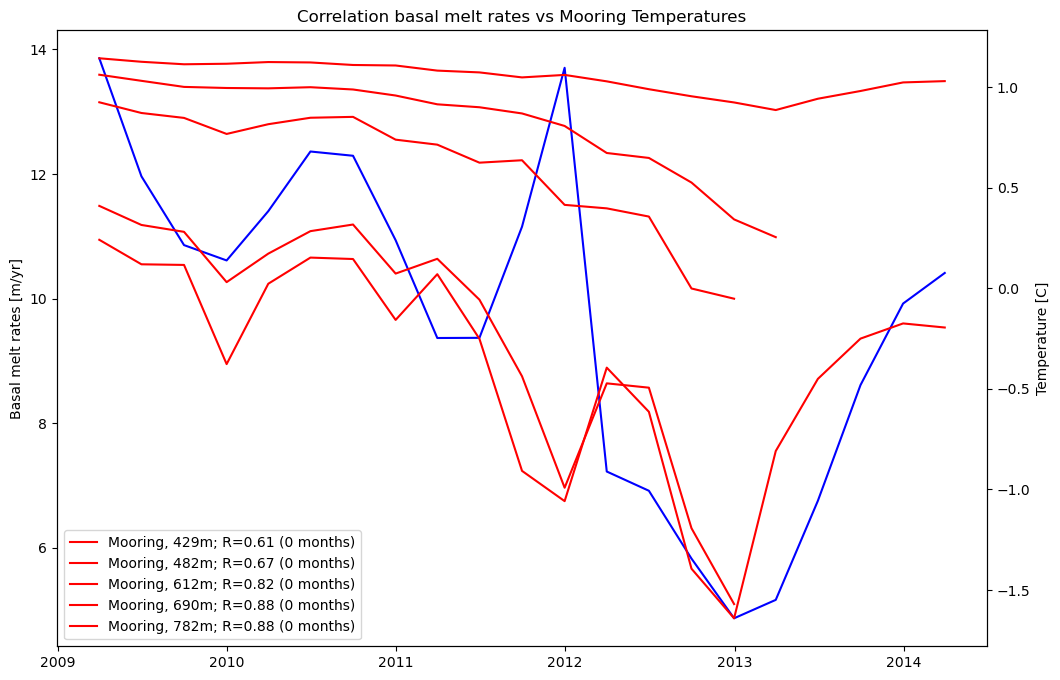

In [28]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(pib_melt_seas.sel(time = slice('2009-01-31','2014-03-31')).time, -pib_melt_seas.sel(time = slice('2009-01-31','2014-03-31')), 'b', label='PIB melt rates')
axb = ax.twinx()
for i in range(5):
    if i==0:
        ds = mo_xr_mon_2
    elif i==1:
        ds = mo_xr_mon_5
    elif i==2:
        ds = mo_xr_mon_4
    elif i==3:
        ds = mo_xr_mon_3
    elif i==4:
        ds = mo_xr_mon_1
    ds_seas = ds.CT[2:].resample({'time':'3M'}).mean('time')
    l = lagcorr( - pib_melt_seas.sel(time = slice(ds_seas.time[0],ds_seas.time[-1])), ds_seas.sel(time = slice(ds_seas.time[0],ds_seas.time[-1])),lag = 0)
    lmax = np.where(l[:,0] == np.amax(l[:,0]))[0] # find year of max correlation
    axb.plot(ds_seas.time,ds_seas,'r',label='Mooring, %dm; R=%.2f (%d months)' %(depth[i], l[lmax[0],0], lmax[0]*3))
axb.legend()
axb.set_ylabel('Temperature [C]')
ax.set_title('Correlation basal melt rates vs Mooring Temperatures')
ax.set_ylabel('Basal melt rates [m/yr]')

- Correlations are very high but should be treated with care as the record is very short when using seasonal data. 
- Most of the correlation comes likely from the trend (see high correlations in deep moorings that are not showing much variability). 
- Still, correlation in the higher moorings seems visible by the eye

### What is happening in the model in 2014?
Why is there such an extreme drop in deep temperatures? Let's have a closer look. 
- Make a map of deep temperature anomaly in 2014 compared to the previous mean. Where is it visible? 

Text(0.5, 1.0, 'T [571.6 m]')

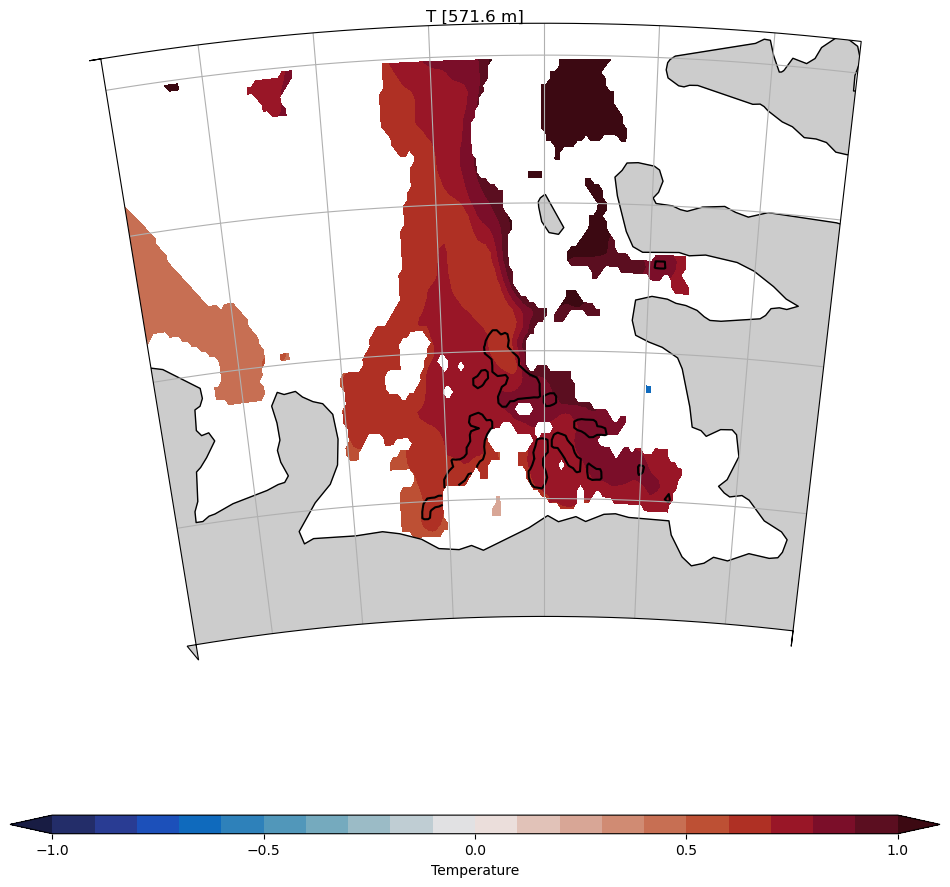

In [29]:
t_control = t_model.sel(st_ocean = 600, method='nearest').sel(time = slice('2009-02-15','2013-02-15')).mean('time')
fig = plt.figure(figsize=(12,12))
ax = plt.subplot(1,1,1,projection = projection_pib)
p1, p2 = spatial_plot(t_control, levels = np.linspace(-1,1,21), cell='t', ax=ax, sect = 'pib', cmap = cm.cm.balance, extend='both')
cb=plt.colorbar(p1,ax=ax, ticks = np.arange(-1,1.5,.5),orientation='horizontal',aspect = 50)
cb.set_label('Temperature')
ax.set_title('T [571.6 m]')

In [30]:
t_model.time[54]

<xarray.DataArray 'time' ()>
array('2013-04-16T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2013-04-16
Attributes:
    long_name:       time
    cartesian_axis:  T
    calendar_type:   GREGORIAN
    bounds:          time_bounds

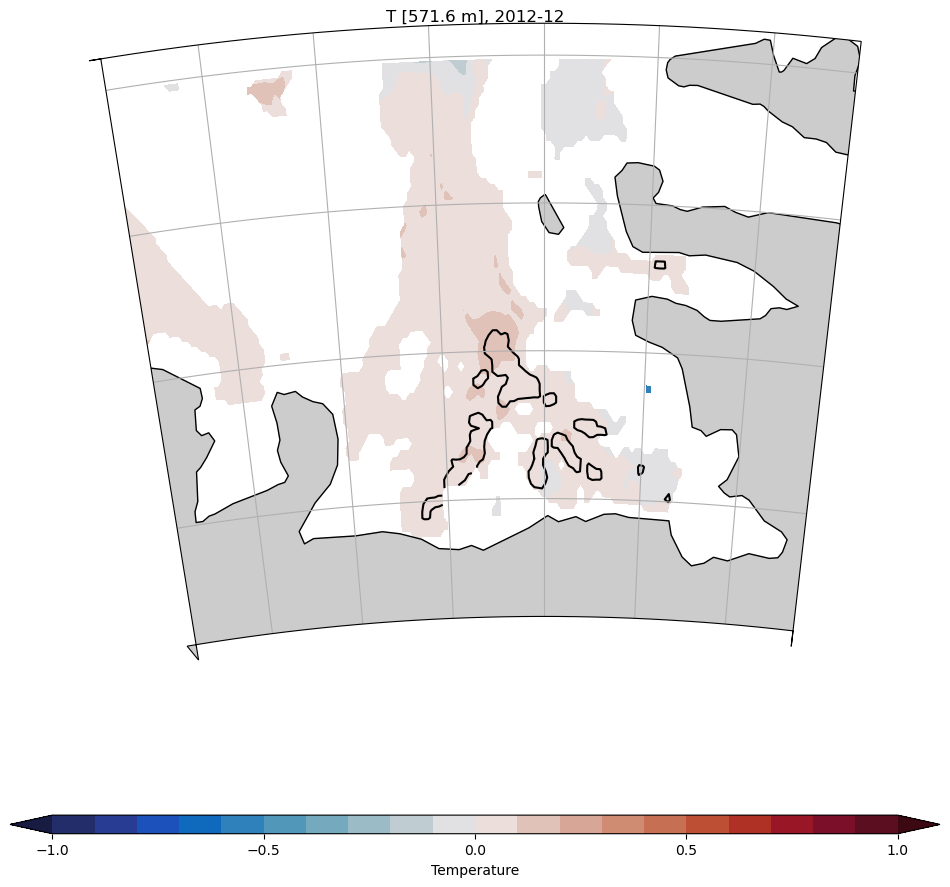

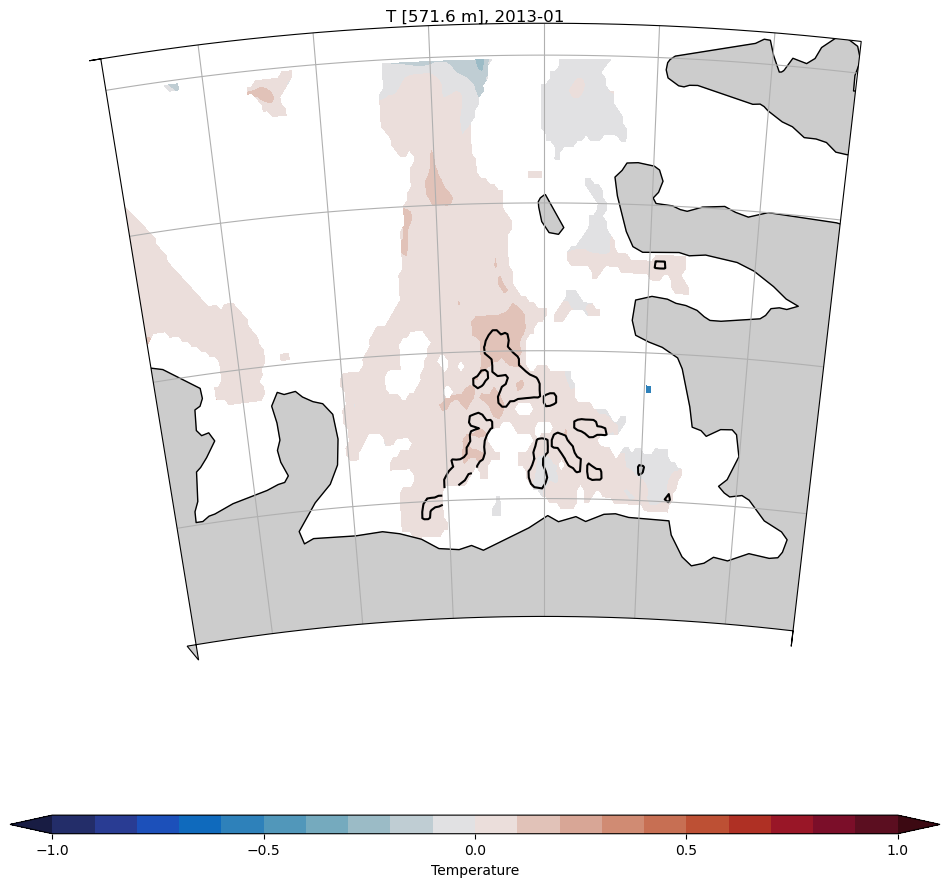

In [31]:
for i in range(2):
    t_anomaly = t_model.sel(st_ocean = 600, method='nearest')[50+i,:,:]-t_control
    fig = plt.figure(figsize=(12,12))
    ax = plt.subplot(1,1,1,projection = projection_pib)
    p1, p2 = spatial_plot(t_anomaly, levels = np.linspace(-1,1,21), cell='t', ax=ax, sect = 'pib', cmap = cm.cm.balance, extend='both')
    cb=plt.colorbar(p1,ax=ax, ticks = np.arange(-1,1.5,.5),orientation='horizontal',aspect = 50)
    cb.set_label('Temperature')
    titstr = str(t_anomaly.time.values)[:7]
    ax.set_title('T [571.6 m], %s' %(titstr))
    figpath = '/home/581/or6852/movies/mooring/t570_anom_'+titstr+'.png'
    #plt.savefig(figpath)
    #plt.close()

In [57]:
make_movie(instr = '/home/581/or6852/movies/mooring/t570_anom_*.png', outstr = '/home/581/or6852/movies/mooring_t_event2014.avi')

This is so weird. Make a movie showing the propagation of the anomaly. 

On the longer timescale the whole period 2009-2014 looks like a cold phase. Let's redo the Hovmoller with temperature anomalies relative to the climatology:


In [32]:
start_alt = '1984-01-01 00:00:00'
tlong = cc.querying.getvar(experiment, 'temp', session,
                       start_time=start_alt, end_time=end).sel(yt_ocean=slice(-77,-72)).sel(xt_ocean=slice(-115,-95)).sel(st_ocean=slice(0,1000))

In [33]:
tlo = tlong.load()-273.15

In [34]:
t_mooring_long = tlo.sel(yt_ocean = slice(lats,latn)).sel(xt_ocean = slice(lonw,lone)).weighted(area_t).mean(dim=('xt_ocean','yt_ocean'))
t_moo_an = t_mooring_long.groupby("time.month")-t_mooring_long.groupby("time.month").mean('time')
#t_moo_an = t_mooring_long - t_mooring_long.mean('time')

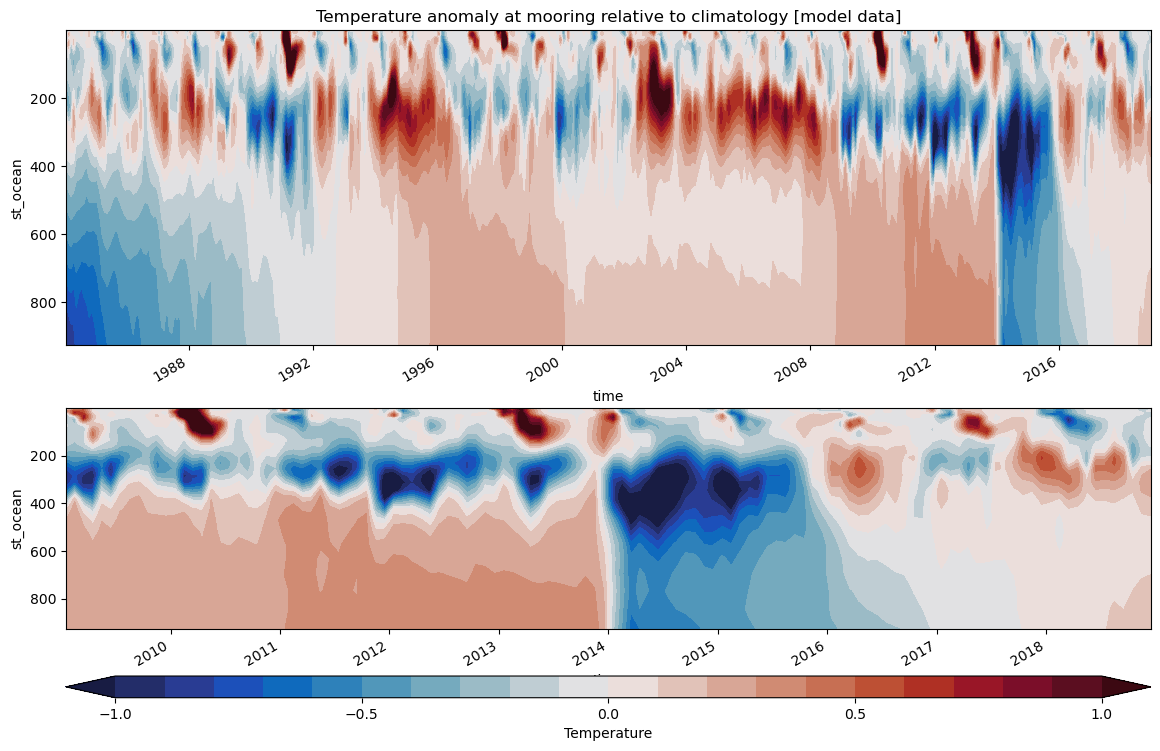

In [35]:
fig, ax = plt.subplots(2,1,figsize=(14,9))
p1 = t_moo_an.sel(time=slice(start_alt,end)).plot.contourf(ax=ax[0],x='time',y='st_ocean',add_colorbar = False, levels = np.linspace(-1,1,21),extend='both',cmap = cm.cm.balance)
ax[0].invert_yaxis()
ax[0].set_title('Temperature anomaly at mooring relative to climatology [model data]')
p1 = t_moo_an.sel(time=slice(start,end)).plot.contourf(ax=ax[1],x='time',y='st_ocean',add_colorbar = False, levels = np.linspace(-1,1,21),extend='both',cmap = cm.cm.balance)
ax[1].invert_yaxis()
cb=plt.colorbar(p1,ax=ax[1], ticks = np.arange(-1,1.5,.5),orientation='horizontal',aspect = 50)
cb.set_label('Temperature')

#plt.savefig('/home/581/or6852/plots/mooring_t_anomaly_ts.png')

Let's look at sea ice. Apparently there was a sea ice minimum during that time. Could that have an effect? 

In [36]:
yt_ocean = cc.querying.getvar(experiment,'yt_ocean',session, n=-1).sel(yt_ocean=slice(-90,-72))
yt_ocean.load()

<xarray.DataArray 'yt_ocean' (yt_ocean: 216)>
array([-81.108632, -81.066392, -81.024153, ..., -72.111649, -72.06941 ,
       -72.02717 ])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -72.11 -72.07 -72.03
Attributes:
    long_name:       tcell latitude
    units:           degrees_N
    cartesian_axis:  Y
    ncfiles:         ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg...
    contact:         Andrew Kiss
    email:           andrew.kiss@anu.edu.au
    created:         2020-08-20
    description:     0.1 degree ACCESS-OM2 global model configuration under i...
    notes:           Run configuration and history: https://github.com/COSIMA...

In [39]:
f=xr.open_dataset('/g/data/jk72/pas561/jnb/ensoant/data/taux_01deg_jra55v140_iaf_cycle2_5801to1812.nc',engine='netcdf4') 
taux = f.tau_x.sel(yu_ocean = slice(-77,-72)).sel(xu_ocean = slice(-115,-95))
taux

<xarray.DataArray 'tau_x' (time: 61, yu_ocean: 119, xu_ocean: 200)>
[1451800 values with dtype=float32]
Coordinates:
  * time      (time) datetime64[ns] 1958-12-31 1959-12-31 ... 2018-12-31
  * xu_ocean  (xu_ocean) float64 -114.9 -114.8 -114.7 ... -95.2 -95.1 -95.0
  * yu_ocean  (yu_ocean) float64 -76.99 -76.95 -76.91 ... -72.09 -72.05 -72.01

In [41]:
aice = cc.querying.getvar(experiment, 'aice_m', session, frequency = '1 monthly',
                       start_time=start_alt, end_time=end).sel(nj=slice(98,216)).sel(ni=slice(1650,1850)).resample({'time':'Y'}).mean('time')
aice['ni'] = t['xt_ocean'].values
aice['nj'] = t['yt_ocean'].values
aice = aice.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
#aice = aice.sel(yu_ocean=slice(-90,-60))
aice

<xarray.DataArray 'aice_m' (time: 36, yt_ocean: 118, xt_ocean: 200)>
dask.array<transpose, shape=(36, 118, 200), dtype=float32, chunksize=(1, 118, 150), chunktype=numpy.ndarray>
Coordinates:
    TLAT      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(118, 150), meta=np.ndarray>
    ULON      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(118, 150), meta=np.ndarray>
    ULAT      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(118, 150), meta=np.ndarray>
    TLON      (yt_ocean, xt_ocean) float32 dask.array<chunksize=(118, 150), meta=np.ndarray>
  * time      (time) datetime64[ns] 1984-12-31 1985-12-31 ... 2019-12-31
  * xt_ocean  (xt_ocean) float64 -115.0 -114.9 -114.8 ... -95.25 -95.15 -95.05
  * yt_ocean  (yt_ocean) float64 -76.97 -76.93 -76.88 ... -72.11 -72.07 -72.03
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2020-08-20
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

In [48]:
t_mooring_long_an = t_mooring_long.resample({'time':'Y'}).mean('time').sel(time=slice(start_alt,end))

Text(0.5, 1.0, 'Sea Ice at Mooring')

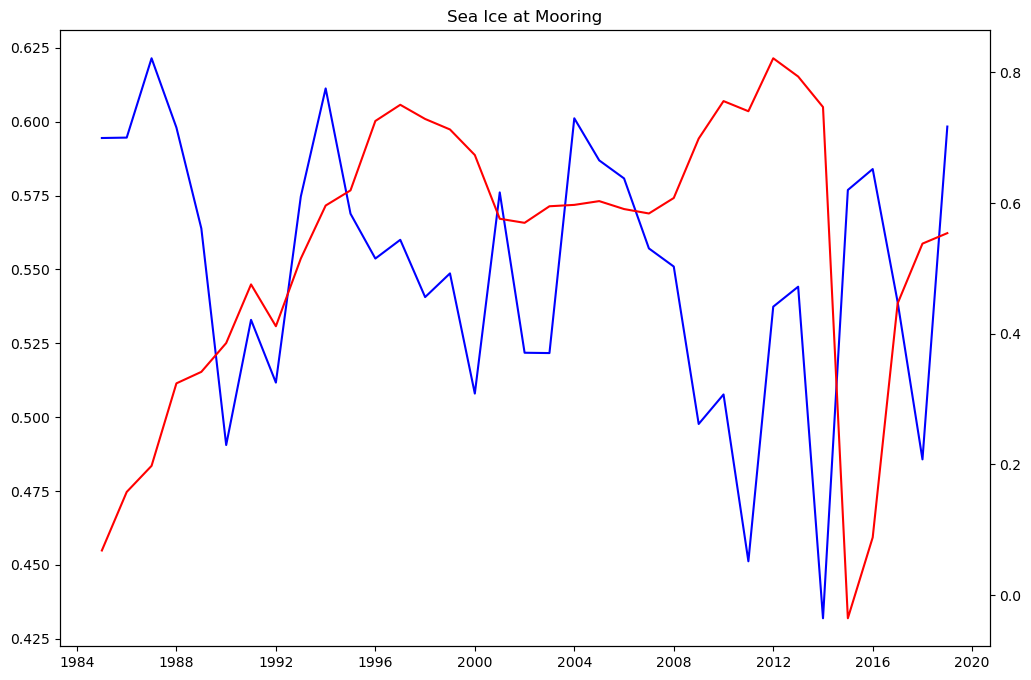

In [49]:
# Plot aice over mooring region: 
aice_mooring = aice.sel(time=slice(start_alt,end)).sel(yt_ocean = slice(lats,latn)).sel(xt_ocean = slice(lonw,lone)).weighted(area_t).mean(dim=('xt_ocean','yt_ocean'))
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(aice_mooring.time,aice_mooring,color='b')
axb = ax.twinx()
axb.plot(t_mooring_long_an.time,t_mooring_long_an.sel(st_ocean=570,method='nearest'),color='r')
plt.title('Sea Ice at Mooring')

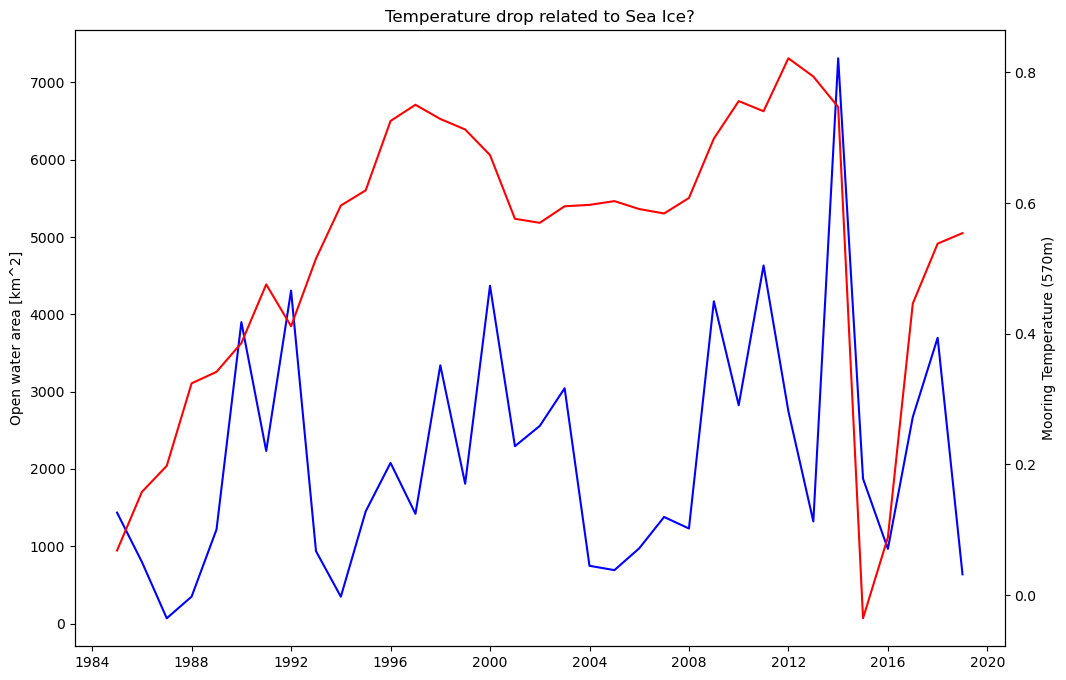

In [67]:
aice_around = aice.sel(time=slice(start_alt,end)).weighted(area_t).mean(dim=('xt_ocean','yt_ocean'))
open_w = area_t.where(aice<0.5).sum({'xt_ocean','yt_ocean'}).values
fig, ax = plt.subplots(1,1,figsize=(12,8))
#ax.plot(aice_around.time,aice_around,color='b')
ax.plot(aice.time[:-1],1e-6*open_w[:-1],color='b')
axb = ax.twinx()
axb.plot(t_mooring_long_an.time,t_mooring_long_an.sel(st_ocean=570,method='nearest'),color='r')
ax.set_ylabel('Open water area [km^2]')
axb.set_ylabel('Mooring Temperature (570m)')
plt.title('Temperature drop related to Sea Ice?')
#plt.savefig('/home/581/or6852/plots/mooring_t_drop_sea_ice.png')

There is a sea ice mimum in 2014, but it is not very outstanding (there was another just in 2011 of similar magnitude...). I do not think it explains this temperature drop.

In [58]:
area_t.where(aice>0.5).sum({'xt_ocean','yt_ocean'}).values

array([1.20944545e+11, 1.21582412e+11, 1.22311328e+11, 1.22030992e+11,
       1.21162586e+11, 1.18480130e+11, 1.20146873e+11, 1.18072492e+11,
       1.21442806e+11, 1.22032059e+11, 1.20928499e+11, 1.20300894e+11,
       1.20960033e+11, 1.19039037e+11, 1.20570794e+11, 1.18008722e+11,
       1.20085092e+11, 1.19822780e+11, 1.19335636e+11, 1.21632230e+11,
       1.21688540e+11, 1.21406139e+11, 1.21000953e+11, 1.21150037e+11,
       1.18209915e+11, 1.19555271e+11, 1.17746996e+11, 1.19634701e+11,
       1.21058386e+11, 1.15066731e+11, 1.20505488e+11, 1.21413706e+11,
       1.19707466e+11, 1.18682569e+11, 1.21742928e+11, 1.60535679e+10])

### HVE - WMP decomposition for mooring:

In [35]:
# First, we need to create a profile that is filled with linear interpolation
mooring_grid = x
mo_xr_1

<xarray.Dataset>
Dimensions:  (time: 177632)
Coordinates:
  * time     (time) datetime64[ns] 2009-01-22T09:30:01.459259136 ... 2014-02-...
Data variables:
    T        (time) float64 1.209 1.21 1.21 1.209 ... 1.092 1.087 1.095 1.096
    CT       (time) float64 1.167 1.167 1.167 1.167 ... 1.051 1.046 1.053 1.055
    SA       (time) float64 34.86 34.86 34.86 34.86 ... 34.64 34.65 34.64 34.64
    d        (time) float64 783.0 783.2 783.1 783.1 ... 783.0 782.9 782.9 782.9

In [48]:
xr.concat((mo_xr_mon_2,mo_xr_mon_1),dim='depth').assign_coords(depth=[429,783]).interp(depth)

<xarray.Dataset>
Dimensions:  (depth: 2, time: 62)
Coordinates:
  * time     (time) datetime64[ns] 2009-01-31 2009-02-28 ... 2014-02-28
  * depth    (depth) int64 429 783
Data variables:
    T        (depth, time) float64 0.2402 0.2652 0.258 ... 1.07 1.061 1.079
    CT       (depth, time) float64 0.2229 0.2477 0.2405 ... 1.029 1.02 1.038
    SA       (depth, time) float64 34.51 34.51 34.52 34.48 ... 34.64 34.64 34.64
    d        (depth, time) float64 429.3 430.4 430.6 431.0 ... 783.0 783.0 783.0

In [41]:
dvec = np.arange(400,500,10)

In [46]:
mo_xr_mon_1.expand_dims('depth').assign_coords(depth=783)

ValueError: dimension 'depth' already exists as a scalar variable